<a href="https://colab.research.google.com/github/jainriya9/DeepFake-Detection/blob/main/implementation_using_mfcc%2C_fft_in_pvt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def compute_fft(image):
    fft_img = np.fft.fft2(image)
    fft_img_shifted = np.fft.fftshift(fft_img)
    magnitude_spectrum = 20 * np.log(np.abs(fft_img_shifted) + 1)
    return magnitude_spectrum

def compute_mfcc(image, sr=22050, n_mfcc=13):
    image_flattened = image.flatten().astype(np.float32)
    image_normalized = image_flattened / np.max(np.abs(image_flattened))
    mfccs = librosa.feature.mfcc(y=image_normalized, sr=sr, n_mfcc=n_mfcc)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs

# Normalize MFCCs to have zero mean and unit variance
scaler = StandardScaler()

def process_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    image_resized = cv2.resize(image, (224, 224))

    fft_features = compute_fft(image_resized)
    mfcc_features = compute_mfcc(image_resized)
    mfcc_features = scaler.fit_transform(mfcc_features.reshape(-1, 1)).flatten()

    return fft_features, mfcc_features

# Example usage
real_image_path = '/content/real.jpg'
fake_image_path = '/content/fake.jpg'

real_fft_features, real_mfcc_features = process_image(real_image_path)
fake_fft_features, fake_mfcc_features = process_image(fake_image_path)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.models import Model

def create_model():
    # Input layers
    fft_input = Input(shape=(224, 224), name='fft_input')
    mfcc_input = Input(shape=(13,), name='mfcc_input')

    # FFT branch
    x = Conv2D(32, (3, 3), activation='relu')(tf.expand_dims(fft_input, axis=-1))
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    # Concatenate FFT and MFCC features
    x = Concatenate()([x, mfcc_input])

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=[fft_input, mfcc_input], outputs=output)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fft_input (InputLayer)      [(None, 224, 224)]           0         []                            
                                                                                                  
 tf.expand_dims (TFOpLambda  (None, 224, 224, 1)          0         ['fft_input[0][0]']           
 )                                                                                                
                                                                                                  
 conv2d (Conv2D)             (None, 222, 222, 32)         320       ['tf.expand_dims[0][0]']      
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)         0         ['conv2d[0][0]']          

In [ ]:
from tensorflow.keras.utils import Sequence
import os

class DeepfakeDataGenerator(Sequence):
    def __init__(self, real_dir, fake_dir, batch_size=16, shuffle=True):
        # Use glob to find all image files with common extensions
        self.real_images = [img for img in glob.glob(os.path.join(real_dir, '*.[jp][pn][eg]'))]
        self.fake_images = [img for img in glob.glob(os.path.join(fake_dir, '*.[jp][pn][eg]'))]
        self.all_images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.all_images) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.all_images[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        fft_features_batch = []
        mfcc_features_batch = []
        for img_path in batch_images:
            fft_features, mfcc_features = process_image(img_path)
            fft_features_batch.append(fft_features)
            mfcc_features_batch.append(mfcc_features)

        return [np.array(fft_features_batch), np.array(mfcc_features_batch)], np.array(batch_labels)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.all_images))
        if self.shuffle:
            np.random.shuffle(self.indices)

# Paths to your real and fake images
real_dir = '/content/realfolder'
fake_dir = '/content/fakefolder'



In [ ]:
!pip install glob

ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [ ]:
import glob

# Verify the paths and check if they contain image files
print("Real images:", os.listdir(real_dir))
print("Fake images:", os.listdir(fake_dir))

train_generator = DeepfakeDataGenerator(real_dir, fake_dir, batch_size=1)
model.fit(train_generator, epochs=10)

Real images: ['real.jpg', 'real2.jpg']
Fake images: ['fake2.jpg', '.ipynb_checkpoints', 'fake.jpg']
Epoch 1/10
4/4 [==============================] - 6s 1s/step - loss: 3287.7017 - accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 5s 1s/step - loss: 2739.6694 - accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 4s 860ms/step - loss: 1960.8138 - accuracy: 0.2500
Epoch 4/10
4/4 [==============================] - 3s 846ms/step - loss: 2066.3477 - accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 5s 1s/step - loss: 146.7520 - accuracy: 0.7500
Epoch 6/10
4/4 [==============================] - 3s 848ms/step - loss: 606.5623 - accuracy: 0.5000
Epoch 7/10
4/4 [==============================] - 3s 812ms/step - loss: 187.4955 - accuracy: 0.7500
Epoch 8/10
4/4 [==============================] - 4s 891ms/step - loss: 182.9369 - accuracy: 0.5000
Epoch 9/10
4/4 [==============================] - 5s 1s/step - loss: 40.9265 - accuracy: 0.7500
E

In [ ]:
import os

def is_image_file(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif'))

class DeepfakeDataGenerator(Sequence):
    def __init__(self, real_dir, fake_dir, batch_size=16, shuffle=True):
        self.real_images = [os.path.join(real_dir, img) for img in os.listdir(real_dir) if is_image_file(img)]
        self.fake_images = [os.path.join(fake_dir, img) for img in os.listdir(fake_dir) if is_image_file(img)]
        self.all_images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.all_images) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.all_images[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        fft_features_batch = []
        mfcc_features_batch = []
        for img_path in batch_images:
            fft_features, mfcc_features = process_image(img_path)
            fft_features_batch.append(fft_features)
            mfcc_features_batch.append(mfcc_features)

        return [np.array(fft_features_batch), np.array(mfcc_features_batch)], np.array(batch_labels)

    def on_epoch_end(self):
        self.indices = np.arange(len(self.all_images))
        if self.shuffle:
            np.random.shuffle(self.indices)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Concatenate, Dropout
from tensorflow.keras.models import Model

def create_model():
    # Input layers
    fft_input = Input(shape=(224, 224, 1), name='fft_input')
    mfcc_input = Input(shape=(13,), name='mfcc_input')

    # FFT branch
    x = Conv2D(32, (3, 3), activation='relu')(fft_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    # Concatenate FFT and MFCC features
    x = Concatenate()([x, mfcc_input])

    # Fully connected layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2, activation='softmax')(x)

    model = Model(inputs=[fft_input, mfcc_input], outputs=output)

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fft_input (InputLayer)      [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 222, 222, 32)         320       ['fft_input[0][0]']           
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_1[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_2 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d_1[0][0]'

In [ ]:
# Paths to your real and fake images
real_dir = '/content/realfolder'
fake_dir = '/content/fakefolder'

# Create data generator, set batch_size to less than or equal to the number of images you have
train_generator = DeepfakeDataGenerator(real_dir, fake_dir, batch_size=2) # Set batch_size to 2 or 1

# Train the model
model.fit(train_generator, epochs=10)

Epoch 1/10
2/2 [==============================] - 3s 671ms/step - loss: 161.9566 - accuracy: 0.7500
Epoch 2/10
2/2 [==============================] - 1s 673ms/step - loss: 920.4810 - accuracy: 0.5000
Epoch 3/10
2/2 [==============================] - 1s 679ms/step - loss: 16.4957 - accuracy: 0.7500
Epoch 4/10
2/2 [==============================] - 1s 690ms/step - loss: 458.6567 - accuracy: 0.5000
Epoch 5/10
2/2 [==============================] - 1s 665ms/step - loss: 70.9560 - accuracy: 0.5000
Epoch 6/10
2/2 [==============================] - 2s 926ms/step - loss: 16.6433 - accuracy: 0.7500
Epoch 7/10
2/2 [==============================] - 2s 949ms/step - loss: 40.6164 - accuracy: 0.2500
Epoch 8/10
2/2 [==============================] - 1s 656ms/step - loss: 3.3974 - accuracy: 0.5000
Epoch 9/10
2/2 [==============================] - 1s 654ms/step - loss: 9.5719 - accuracy: 0.2500
Epoch 10/10
2/2 [==============================] - 1s 658ms/step - loss: 4.1433 - accuracy: 0.2500


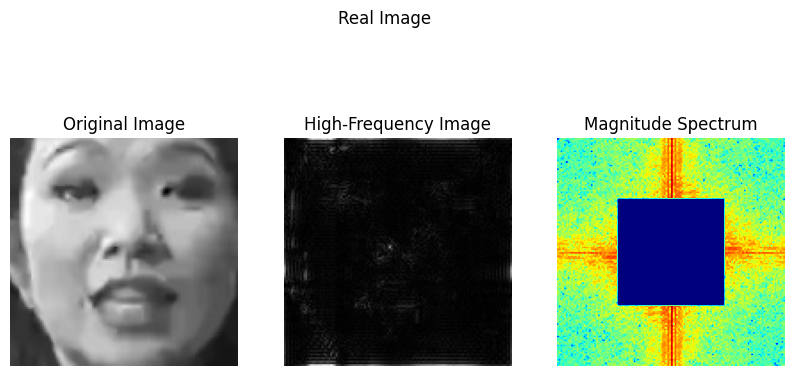

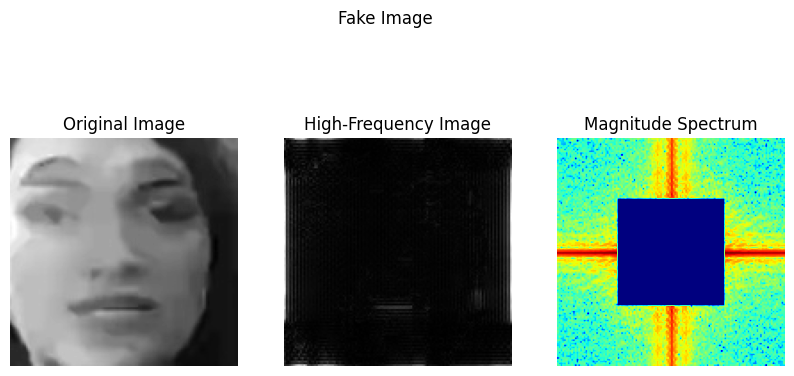

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to extract high-frequency components using FFT
def extract_high_frequency(image, radius=30):
    # Compute the FFT of the image
    fft_img = np.fft.fft2(image)

    # Shift the zero-frequency component to the center
    fft_shifted_img = np.fft.fftshift(fft_img)

    # Get the dimensions of the image
    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2     # center

    # Create a mask with a high-pass filter
    mask = np.ones((rows, cols), np.uint8)
    mask[crow-radius:crow+radius, ccol-radius:ccol+radius] = 0

    # Apply the mask to the shifted FFT
    fft_shifted_img_high_freq = fft_shifted_img * mask

    # Inverse FFT to get the high-frequency image
    ifft_shifted_img = np.fft.ifftshift(fft_shifted_img_high_freq)
    high_freq_img = np.fft.ifft2(ifft_shifted_img)
    high_freq_img = np.abs(high_freq_img)

    # Compute the magnitude spectrum for visualization
    magnitude_spectrum = 20 * np.log(np.abs(fft_shifted_img_high_freq) + 1)

    return high_freq_img, magnitude_spectrum

# Function to visualize the original and high-frequency images
def visualize_images(original_img, high_freq_img, magnitude_spectrum, title):
    plt.figure(figsize=(10, 5))

    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # High-frequency image
    plt.subplot(1, 3, 2)
    plt.imshow(high_freq_img, cmap='gray')
    plt.title('High-Frequency Image')
    plt.axis('off')

    # Magnitude spectrum
    plt.subplot(1, 3, 3)
    plt.imshow(magnitude_spectrum, cmap='jet')
    plt.title('Magnitude Spectrum')
    plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Paths to your real and fake images
real_image_path = '/content/real.jpg'
fake_image_path = '/content/fake.jpg'

# Read the real and fake images in grayscale
real_image = cv2.imread(real_image_path, cv2.IMREAD_GRAYSCALE)
fake_image = cv2.imread(fake_image_path, cv2.IMREAD_GRAYSCALE)

# Extract high-frequency components for real image
high_freq_real, magnitude_spectrum_real = extract_high_frequency(real_image)

# Extract high-frequency components for fake image
high_freq_fake, magnitude_spectrum_fake = extract_high_frequency(fake_image)

# Visualize the original and high-frequency images for real image
visualize_images(real_image, high_freq_real, magnitude_spectrum_real, 'Real Image')

# Visualize the original and high-frequency images for fake image
visualize_images(fake_image, high_freq_fake, magnitude_spectrum_fake, 'Fake Image')


In [ ]:
import librosa

# Function to extract MFCC features from an image
def extract_mfcc(image, sr=22050, n_mfcc=13):
    # Normalize the image and convert it to a 1D array
    image = image.astype(np.float32) / 255.0
    image_1d = image.flatten()

    # Compute MFCC features
    mfccs = librosa.feature.mfcc(y=image_1d, sr=sr, n_mfcc=n_mfcc)

    # Take the mean of the MFCCs
    mfccs_mean = np.mean(mfccs, axis=1)

    return mfccs_mean


In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence

class DeepfakeDataGenerator(Sequence):
    def __init__(self, real_dir, fake_dir, batch_size=16, shuffle=True):
        self.real_images = [os.path.join(real_dir, img) for img in os.listdir(real_dir) if img.endswith(('.jpg', '.png', '.jpeg'))] # Filter for image files
        self.fake_images = [os.path.join(fake_dir, img) for img in os.listdir(fake_dir) if img.endswith(('.jpg', '.png', '.jpeg'))] # Filter for image files
        self.all_images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.all_images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_images = [self.all_images[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        X, y = self.__data_generation(batch_images, batch_labels)
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.all_images))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_images, batch_labels):
        fft_features = []
        mfcc_features = []

        for img_path in batch_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None: # Check if image loaded successfully
                print(f"Failed to load image: {img_path}")
                continue # Skip this image
            img = cv2.resize(img, (224, 224))

            high_freq_img, _ = extract_high_frequency(img)
            fft_features.append(high_freq_img)

            mfcc_feat = extract_mfcc(img)
            mfcc_features.append(mfcc_feat)

        fft_features = np.array(fft_features).reshape(-1, 224, 224, 1)
        mfcc_features = np.array(mfcc_features)

        return [fft_features, mfcc_features], np.array(batch_labels)

# Create data generator
train_generator = DeepfakeDataGenerator('/content/realfolder', '/content/fakefolder', batch_size=1)

In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_model():
    fft_input = Input(shape=(224, 224, 1), name='fft_input')
    mfcc_input = Input(shape=(13,), name='mfcc_input')

    x = Conv2D(32, (3, 3), activation='relu')(fft_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    x = Concatenate()([x, mfcc_input])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=[fft_input, mfcc_input], outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fft_input (InputLayer)      [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 222, 222, 32)         320       ['fft_input[0][0]']           
                                                                                                  
 max_pooling2d_7 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_7[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d_7[0][0]'

In [ ]:
model.fit(train_generator, epochs=10)


Epoch 1/10
4/4 [==============================] - 4s 416ms/step - loss: 1.9962 - accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 2s 421ms/step - loss: 1.8569 - accuracy: 0.2500
Epoch 3/10
4/4 [==============================] - 2s 504ms/step - loss: 10.5903 - accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 3s 727ms/step - loss: 1.1994 - accuracy: 0.5000
Epoch 5/10
4/4 [==============================] - 2s 406ms/step - loss: 0.9299 - accuracy: 0.7500
Epoch 6/10
4/4 [==============================] - 2s 419ms/step - loss: 4.2215 - accuracy: 0.7500
Epoch 7/10
4/4 [==============================] - 2s 445ms/step - loss: 0.7265 - accuracy: 0.7500
Epoch 8/10
4/4 [==============================] - 2s 404ms/step - loss: 0.1128 - accuracy: 1.0000
Epoch 9/10
4/4 [==============================] - 2s 430ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 10/10
4/4 [==============================] - 2s 574ms/step - loss: 0.3257 - accuracy: 0.7500


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
from tensorflow.keras.utils import Sequence

# Function to extract high-frequency components using FFT
def extract_high_frequency(image, radius=30):
    # Compute the FFT of the image
    fft_img = np.fft.fft2(image)

    # Shift the zero-frequency component to the center
    fft_shifted_img = np.fft.fftshift(fft_img)

    # Get the dimensions of the image
    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2     # center

    # Create a mask with a high-pass filter
    mask = np.ones((rows, cols), np.uint8)
    mask[crow-radius:crow+radius, ccol-radius:ccol+radius] = 0

    # Apply the mask to the shifted FFT
    fft_shifted_img_high_freq = fft_shifted_img * mask

    # Inverse FFT to get the high-frequency image
    ifft_shifted_img = np.fft.ifftshift(fft_shifted_img_high_freq)
    high_freq_img = np.fft.ifft2(ifft_shifted_img)
    high_freq_img = np.abs(high_freq_img)

    # Compute the magnitude spectrum for visualization
    magnitude_spectrum = 20 * np.log(np.abs(fft_shifted_img_high_freq) + 1)

    return high_freq_img, magnitude_spectrum

# Function to extract MFCC features from an image
def extract_mfcc(image, sr=22050, n_mfcc=13):
    # Normalize the image and convert it to a 1D array
    image = image.astype(np.float32) / 255.0
    image_1d = image.flatten()

    # Compute MFCC features
    mfccs = librosa.feature.mfcc(y=image_1d, sr=sr, n_mfcc=n_mfcc)

    # Take the mean of the MFCCs
    mfccs_mean = np.mean(mfccs, axis=1)

    return mfccs_mean

# Custom data generator to preprocess images and extract FFT and MFCC features
class DeepfakeDataGenerator(Sequence):
    def __init__(self, real_dir, fake_dir, batch_size=16, shuffle=True):
        self.real_images = [os.path.join(real_dir, img) for img in os.listdir(real_dir) if img.endswith('.jpg')]
        self.fake_images = [os.path.join(fake_dir, img) for img in os.listdir(fake_dir) if img.endswith('.jpg')]
        self.all_images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.all_images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_images = [self.all_images[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        X, y = self.__data_generation(batch_images, batch_labels)
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.all_images))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_images, batch_labels):
        fft_features = []
        mfcc_features = []

        for img_path in batch_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))

            high_freq_img, _ = extract_high_frequency(img)
            fft_features.append(high_freq_img)

            mfcc_feat = extract_mfcc(img)
            mfcc_features.append(mfcc_feat)

        fft_features = np.array(fft_features).reshape(-1, 224, 224, 1)
        mfcc_features = np.array(mfcc_features)

        return [fft_features, mfcc_features], np.array(batch_labels)

# Create data generator
train_generator = DeepfakeDataGenerator('/content/realfolder', '/content/fakefolder', batch_size=1)

# Example: Visualizing a batch
X, y = train_generator[0]
print(X[0].shape)  # FFT features
print(X[1].shape)  # MFCC features
print(y.shape)  # Labels


(1, 224, 224, 1)
(1, 13)
(1,)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_model():
    fft_input = Input(shape=(224, 224, 1), name='fft_input')
    mfcc_input = Input(shape=(13,), name='mfcc_input')

    x = Conv2D(32, (3, 3), activation='relu')(fft_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    x = Concatenate()([x, mfcc_input])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=[fft_input, mfcc_input], outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fft_input (InputLayer)      [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_9 (Conv2D)           (None, 222, 222, 32)         320       ['fft_input[0][0]']           
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_10 (Conv2D)          (None, 109, 109, 64)         18496     ['max_pooling2d_9[0][0]'

In [ ]:
model.fit(train_generator, epochs=10)

Epoch 1/10
4/4 [==============================] - 4s 427ms/step - loss: 1.6471 - accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 2s 443ms/step - loss: 2.5567 - accuracy: 0.2500
Epoch 3/10
4/4 [==============================] - 2s 496ms/step - loss: 3.8798 - accuracy: 0.5000
Epoch 4/10
4/4 [==============================] - 3s 722ms/step - loss: 0.4691 - accuracy: 0.7500
Epoch 5/10
4/4 [==============================] - 2s 432ms/step - loss: 0.8678 - accuracy: 0.7500
Epoch 6/10
4/4 [==============================] - 2s 414ms/step - loss: 3.7220 - accuracy: 0.5000
Epoch 7/10
4/4 [==============================] - 2s 426ms/step - loss: 0.0172 - accuracy: 1.0000
Epoch 8/10
4/4 [==============================] - 2s 426ms/step - loss: 0.4627 - accuracy: 0.7500
Epoch 9/10
4/4 [==============================] - 3s 684ms/step - loss: 0.4212 - accuracy: 0.7500
Epoch 10/10
4/4 [==============================] - 2s 442ms/step - loss: 1.4781 - accuracy: 0.2500


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Function to extract high-frequency components using FFT
def extract_high_frequency(image, radius=30):
    fft_img = np.fft.fft2(image)
    fft_shifted_img = np.fft.fftshift(fft_img)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.uint8)
    mask[crow-radius:crow+radius, ccol-radius:ccol+radius] = 0
    fft_shifted_img_high_freq = fft_shifted_img * mask
    ifft_shifted_img = np.fft.ifftshift(fft_shifted_img_high_freq)
    high_freq_img = np.fft.ifft2(ifft_shifted_img)
    high_freq_img = np.abs(high_freq_img)
    return high_freq_img

# Function to compute MFCCs from spectrogram
def compute_mfcc(spectrogram, n_mfcc=13):
    mfccs = librosa.feature.mfcc(S=spectrogram, n_mfcc=n_mfcc)
    return mfccs

# Function to visualize MFCC and spectrogram
def visualize_mfcc(spectrogram, mfccs, title):
    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    librosa.display.specshow(librosa.amplitude_to_db(spectrogram.squeeze(), ref=np.max),
                             sr=22050, hop_length=512, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()

    plt.subplot(2, 1, 2)
    librosa.display.specshow(mfccs.squeeze(), sr=22050, x_axis='time')
    plt.colorbar()
    plt.title('MFCCs')
    plt.tight_layout()

    plt.suptitle(title)
    plt.show()

# Custom data generator
class DeepfakeDataGenerator(Sequence):
    def __init__(self, real_dir, fake_dir, batch_size=16, shuffle=True):
        self.real_images = [os.path.join(real_dir, img) for img in os.listdir(real_dir) if img.endswith('.jpg')]
        self.fake_images = [os.path.join(fake_dir, img) for img in os.listdir(fake_dir) if img.endswith('.jpg')]
        self.all_images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.all_images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.all_images[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]
        X, y = self.__data_generation(batch_images, batch_labels)
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.all_images))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_images, batch_labels):
        fft_features = []
        mfcc_features = []

        for img_path in batch_images:
            # ... (rest of the code remains unchanged)

            fft_features = np.array(fft_features).reshape(-1, 224, 224, 1)
        # Reshape MFCC features to have the correct number of features
        mfcc_features = np.array(mfcc_features).reshape(-1, 13 * 173) # Reshape to match Dense layer input

        return [fft_features, mfcc_features], np.array(batch_labels)

# Create the model
def create_model():
    fft_input = Input(shape=(224, 224, 1), name='fft_input')
    mfcc_input = Input(shape=(173 * 13,), name='mfcc_input')

    x = Conv2D(32, (3, 3), activation='relu')(fft_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    x = Concatenate()([x, mfcc_input])
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[fft_input, mfcc_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Prepare the data generators
train_generator = DeepfakeDataGenerator('/content/realfolder', '/content/fakefolder', batch_size=1)
validation_generator = DeepfakeDataGenerator('/content/validation_realfolder', '/content/validation_fakefolder', batch_size=1) # Create a separate validation generator


# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Create and train the model
model = create_model()
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,  # Use the validation generator
    callbacks=[early_stopping, checkpoint]
)


Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0000e+00

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - 10s 3s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
4/4 [==============================] - 4s 1s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
4/4 [==============================] - 2s 426ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
4/4 [==============================] - 2s 614ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 3s 744ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 3s 652ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
from tensorflow.keras.utils import Sequence

# Function to extract high-frequency components using FFT
def extract_high_frequency(image, radius=30):
    # Compute the FFT of the image
    fft_img = np.fft.fft2(image)

    # Shift the zero-frequency component to the center
    fft_shifted_img = np.fft.fftshift(fft_img)

    # Get the dimensions of the image
    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2     # center

    # Create a mask with a high-pass filter
    mask = np.ones((rows, cols), np.uint8)
    mask[crow-radius:crow+radius, ccol-radius:ccol+radius] = 0

    # Apply the mask to the shifted FFT
    fft_shifted_img_high_freq = fft_shifted_img * mask

    # Inverse FFT to get the high-frequency image
    ifft_shifted_img = np.fft.ifftshift(fft_shifted_img_high_freq)
    high_freq_img = np.fft.ifft2(ifft_shifted_img)
    high_freq_img = np.abs(high_freq_img)

    # Compute the magnitude spectrum for visualization
    magnitude_spectrum = 20 * np.log(np.abs(fft_shifted_img_high_freq) + 1)

    return high_freq_img, magnitude_spectrum

# Function to extract MFCC features from an image
def extract_mfcc(image, sr=22050, n_mfcc=13):
    # Normalize the image and convert it to a 1D array
    image = image.astype(np.float32) / 255.0
    image_1d = image.flatten()

    # Compute MFCC features
    mfccs = librosa.feature.mfcc(y=image_1d, sr=sr, n_mfcc=n_mfcc)

    # Take the mean of the MFCCs
    mfccs_mean = np.mean(mfccs, axis=1)

    return mfccs_mean

# Custom data generator to preprocess images and extract FFT and MFCC features
class DeepfakeDataGenerator(Sequence):
    def __init__(self, real_dir, fake_dir, batch_size=16, shuffle=True):
        self.real_images = [os.path.join(real_dir, img) for img in os.listdir(real_dir) if img.endswith('.jpg')]
        self.fake_images = [os.path.join(fake_dir, img) for img in os.listdir(fake_dir) if img.endswith('.jpg')]
        self.all_images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.all_images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        batch_images = [self.all_images[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        X, y = self.__data_generation(batch_images, batch_labels)
        return X, y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.all_images))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __data_generation(self, batch_images, batch_labels):
        fft_features = []
        mfcc_features = []

        for img_path in batch_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))

            high_freq_img, _ = extract_high_frequency(img)
            fft_features.append(high_freq_img)

            mfcc_feat = extract_mfcc(img)
            mfcc_features.append(mfcc_feat)

        fft_features = np.array(fft_features).reshape(-1, 224, 224, 1)
        mfcc_features = np.array(mfcc_features)

        return [fft_features, mfcc_features], np.array(batch_labels)

# Create data generator
train_generator = DeepfakeDataGenerator('/content/realfolder', '/content/fakefolder', batch_size=1)

# Example: Visualizing a batch
X, y = train_generator[0]
print(X[0].shape)  # FFT features
print(X[1].shape)  # MFCC features
print(y.shape)  # Labels


(1, 224, 224, 1)
(1, 13)
(1,)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Concatenate, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Add, Reshape, GlobalAveragePooling2D, UpSampling2D

# Transformer block
def transformer_block(x, num_heads, key_dim, ff_dim, dropout=0.1):
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    attn_output = Dropout(dropout)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(x + attn_output)

    ffn_output = Dense(ff_dim, activation='relu')(out1)
    ffn_output = Dense(x.shape[-1])(ffn_output)
    ffn_output = Dropout(dropout)(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)

# Pyramid Vision Transformer
def create_pvt_model(input_shape_fft, input_shape_mfcc):
    fft_input = Input(shape=input_shape_fft, name='fft_input')
    mfcc_input = Input(shape=input_shape_mfcc, name='mfcc_input')

    # FFT branch
    x = Conv2D(64, (4, 4), strides=4, padding='same')(fft_input)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Reshape((-1, x.shape[-1]))(x)  # Flatten spatial dimensions
    x = transformer_block(x, num_heads=4, key_dim=64, ff_dim=256)
    x = Reshape((56, 56, -1))(x)  # Restore spatial dimensions
    x = MaxPooling2D((2, 2))(x)

    # Hierarchical structure
    x = Conv2D(128, (2, 2), strides=2, padding='same')(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Reshape((-1, x.shape[-1]))(x)
    x = transformer_block(x, num_heads=4, key_dim=128, ff_dim=512)
    x = Reshape((28, 28, -1))(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (2, 2), strides=2, padding='same')(x)
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Reshape((-1, x.shape[-1]))(x)
    x = transformer_block(x, num_heads=4, key_dim=256, ff_dim=1024)
    x = Reshape((14, 14, -1))(x)
    x = GlobalAveragePooling2D()(x)

    # MFCC branch
    y = Dense(128, activation='relu')(mfcc_input)
    y = Dropout(0.5)(y)
    y = Reshape((1, 128))(y)
    y = tf.keras.layers.RepeatVector(x.shape[1])(y)


    # Concatenate FFT and MFCC branches
    combined = Concatenate(axis=-1)([x, y])  # Concatenate along the last axis
    combined = Dense(128, activation='relu')(combined)
    combined = Dropout(0.5)(combined)
    output = Dense(1, activation='sigmoid')(combined)  # Binary classification

    model = Model(inputs=[fft_input, mfcc_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define input shapes
input_shape_fft = (224, 224, 1)
input_shape_mfcc = (173 * 13,)  # Adjust according to your MFCC feature shape

# Create and summarize the model
model = create_pvt_model(input_shape_fft, input_shape_mfcc)
model.summary()


ValueError: Input 0 of layer "repeat_vector" is incompatible with the layer: expected ndim=2, found ndim=3. Full shape received: (None, 1, 128)

In [ ]:
import os
import numpy as np
import cv2
import librosa
from tensorflow.keras.utils import Sequence

# Function to extract high-frequency components using FFT
def extract_high_frequency(image, radius=30):
    fft_img = np.fft.fft2(image)
    fft_shifted_img = np.fft.fftshift(fft_img)
    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.ones((rows, cols), np.uint8)
    mask[crow-radius:crow+radius, ccol-radius:ccol+radius] = 0
    fft_shifted_img_high_freq = fft_shifted_img * mask
    ifft_shifted_img = np.fft.ifftshift(fft_shifted_img_high_freq)
    high_freq_img = np.fft.ifft2(ifft_shifted_img)
    high_freq_img = np.abs(high_freq_img)
    return high_freq_img

# Function to compute MFCCs from an image
def compute_mfcc(image, n_mfcc=13):
    spectrogram = librosa.feature.melspectrogram(y=image.astype(float), sr=22050, n_fft=2048, hop_length=512)
    mfccs = librosa.feature.mfcc(S=spectrogram, n_mfcc=n_mfcc)
    return mfccs

# Custom data generator
class DeepfakeDataGenerator(Sequence):
    def __init__(self, real_dir, fake_dir, batch_size=2, shuffle=True):
        self.real_images = [os.path.join(real_dir, img) for img in os.listdir(real_dir) if img.endswith('.jpg')]
        self.fake_images = [os.path.join(fake_dir, img) for img in os.listdir(fake_dir) if img.endswith('.jpg')]
        self.all_images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.all_images) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.all_images[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        fft_batch = []
        mfcc_batch = []

        for img_path in batch_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))
            img_normalized = img.astype(np.float32) / 255.0

            fft_img = extract_high_frequency(img_normalized)
            fft_img = np.expand_dims(fft_img, axis=-1)

            mfccs = compute_mfcc(img_normalized)
            mfccs = mfccs.flatten()  # Flatten to create a 1D array

            fft_batch.append(fft_img)
            mfcc_batch.append(mfccs)

        fft_batch = np.array(fft_batch)
        mfcc_batch = np.array(mfcc_batch)
        batch_labels = np.array(batch_labels)

        return {'fft_input': fft_batch, 'mfcc_input': mfcc_batch}, batch_labels

    def on_epoch_end(self):
        self.indices = np.arange(len(self.all_images))
        if self.shuffle:
            np.random.shuffle(self.indices)

# Paths to your real and fake images directories
real_dir = '/content/realfolder'
fake_dir = '/content/fakefolder'

# Create data generator
train_generator = DeepfakeDataGenerator(real_dir, fake_dir, batch_size=1)

# Create and summarize the model
model = create_pvt_model((224, 224, 1), (1, 173 * 13,)) # Adjust input shape for MFCC branch
model.summary()

# Train the model
model.fit(train_generator, epochs=10)


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fft_input (InputLayer)      [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 conv2d_18 (Conv2D)          (None, 56, 56, 64)           1088      ['fft_input[0][0]']           
                                                                                                  
 layer_normalization_54 (La  (None, 56, 56, 64)           128       ['conv2d_18[0][0]']           
 yerNormalization)                                                                                
                                                                                                  
 reshape_39 (Reshape)        (None, 3136, 64)             0         ['layer_normalization_54

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=224
  warnings.warn(


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node model_4/dense_56/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-8-c9e011b0a64b>", line 86, in <cell line: 86>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 255, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

Matrix size-incompatible: In[0]: [1,2912], In[1]: [2249,128]
	 [[{{node model_4/dense_56/Relu}}]] [Op:__inference_train_function_27291]

In [ ]:
import os
import numpy as np
import cv2
import librosa
from tensorflow.keras.utils import Sequence

# Function to extract high-frequency components using FFT
def extract_high_frequency(image, radius=30):
    fft_img = np.fft.fft2(image)
    fft_shifted_img = np.fft.fftshift(fft_img)
    rows, cols = image.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.ones((rows, cols), np.uint8)
    mask[crow-radius:crow+radius, ccol-radius:ccol+radius] = 0
    fft_shifted_img_high_freq = fft_shifted_img * mask
    ifft_shifted_img = np.fft.ifftshift(fft_shifted_img_high_freq)
    high_freq_img = np.fft.ifft2(ifft_shifted_img)
    high_freq_img = np.abs(high_freq_img)
    return high_freq_img

# Function to compute MFCCs from an image
def compute_mfcc(image, n_mfcc=13):
    spectrogram = librosa.feature.melspectrogram(y=image.astype(float), sr=22050, n_fft=2048, hop_length=512)
    mfccs = librosa.feature.mfcc(S=spectrogram, n_mfcc=n_mfcc)
    return mfccs

# Custom data generator
class DeepfakeDataGenerator(Sequence):
    def __init__(self, real_dir, fake_dir, batch_size=2, shuffle=True):
        self.real_images = [os.path.join(real_dir, img) for img in os.listdir(real_dir) if img.endswith('.jpg')]
        self.fake_images = [os.path.join(fake_dir, img) for img in os.listdir(fake_dir) if img.endswith('.jpg')]
        self.all_images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.all_images) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.all_images[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        fft_batch = []
        mfcc_batch = []

        for img_path in batch_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224, 224))
            img_normalized = img.astype(np.float32) / 255.0

            fft_img = extract_high_frequency(img_normalized)
            fft_img = np.expand_dims(fft_img, axis=-1)

            mfccs = compute_mfcc(img_normalized)
            mfccs = mfccs.flatten()  # Flatten to create a 1D array

            fft_batch.append(fft_img)
            mfcc_batch.append(mfccs)

        fft_batch = np.array(fft_batch)
        mfcc_batch = np.array(mfcc_batch)
        batch_labels = np.array(batch_labels)

        return {'fft_input': fft_batch, 'mfcc_input': mfcc_batch}, batch_labels

    def on_epoch_end(self):
        self.indices = np.arange(len(self.all_images))
        if self.shuffle:
            np.random.shuffle(self.indices)


In [ ]:
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Concatenate, Dropout, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_pvt_model(fft_shape, mfcc_shape):
    fft_input = Input(shape=fft_shape, name='fft_input')
    mfcc_input = Input(shape=mfcc_shape, name='mfcc_input')

    x = Conv2D(32, (3, 3), activation='relu')(fft_input)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    # Reshape MFCC input to have a compatible shape for concatenation
    mfcc_reshaped = Reshape((mfcc_shape[0],))(mfcc_input)  # Reshape to (num_mfcc_features,)
    mfcc_expanded = Dense(x.shape[-1], activation='relu')(mfcc_reshaped) # Expand to match the number of units in the FFT branch

    x = Concatenate()([x, mfcc_expanded]) # Concatenate along the last axis (default)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=[fft_input, mfcc_input], outputs=output)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Paths to your real and fake images directories
real_dir = '/content/realfolder'
fake_dir = '/content/fakefolder'

# Create data generator
train_generator = DeepfakeDataGenerator(real_dir, fake_dir, batch_size=1)

# Create and summarize the model
model = create_pvt_model((224, 224, 1), (173 * 13,))
model.summary()

# Train the model
model.fit(train_generator, epochs=10)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, GlobalAveragePooling1D, LayerNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, patch_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.projection = Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size)

    def call(self, x):
        x = self.projection(x)
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, -1, x.shape[-1]))
        return x

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super(TransformerBlock, self).__init__()
        self.layer_norm1 = LayerNormalization()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.layer_norm2 = LayerNormalization()
        self.mlp = tf.keras.Sequential([
            Dense(mlp_dim, activation='relu'),
            Dense(embed_dim)
        ])

    def call(self, x):
        x_norm = self.layer_norm1(x)
        attn_output = self.mha(x_norm, x_norm)
        x = Add()([x, attn_output])
        x_norm = self.layer_norm2(x)
        mlp_output = self.mlp(x_norm)
        x = Add()([x, mlp_output])
        return x

def create_pvt_model(input_shape_fft, input_shape_mfcc, patch_size=16, embed_dim=64, num_heads=4, mlp_dim=128, num_blocks=4):
    fft_input = Input(shape=input_shape_fft, name='fft_input')
    mfcc_input = Input(shape=input_shape_mfcc, name='mfcc_input')

    # Patch embedding
    x = PatchEmbedding(patch_size, embed_dim)(fft_input)

    # Transformer blocks
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, mlp_dim)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Concatenate with MFCC features
    x = layers.Concatenate()([x, mfcc_input])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=[fft_input, mfcc_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
import os
import numpy as np
import cv2
import librosa
from tensorflow.keras.utils import Sequence

# Function to extract high-frequency components using FFT
def extract_high_frequency(image, radius=30):
    fft_img = np.fft.fft2(image)
    fft_shifted_img = np.fft.fftshift(fft_img)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), np.uint8)
    mask[crow-radius:crow+radius, ccol-radius+radius] = 0
    fft_shifted_img_high_freq = fft_shifted_img * mask
    ifft_shifted_img = np.fft.ifftshift(fft_shifted_img_high_freq)
    high_freq_img = np.fft.ifft2(ifft_shifted_img)
    high_freq_img = np.abs(high_freq_img)
    return high_freq_img

# Function to compute MFCCs from an image
def compute_mfcc(image, n_mfcc=13):
    image_resized = cv2.resize(image, (128, 128))
    spectrogram = librosa.feature.melspectrogram(y=image_resized.astype(float), sr=22050, n_fft=2048, hop_length=512)
    mfccs = librosa.feature.mfcc(S=spectrogram, n_mfcc=n_mfcc)
    return mfccs

# Custom data generator
class DeepfakeDataGenerator(Sequence):
    def __init__(self, real_dir, fake_dir, batch_size=2, shuffle=True):
        self.real_images = [os.path.join(real_dir, img) for img in os.listdir(real_dir) if img.endswith('.jpg')]
        self.fake_images = [os.path.join(fake_dir, img) for img in os.listdir(fake_dir) if img.endswith('.jpg')]
        self.all_images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.all_images) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.all_images[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        fft_batch = []
        mfcc_batch = []

        for img_path in batch_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))  # Reduce image size
            img_normalized = img.astype(np.float32) / 255.0

            fft_img = extract_high_frequency(img_normalized)
            fft_img = np.expand_dims(fft_img, axis=-1)

            mfccs = compute_mfcc(img_normalized)
            mfccs = mfccs.flatten()  # Flatten to create a 1D array

            fft_batch.append(fft_img)
            mfcc_batch.append(mfccs)

        fft_batch = np.array(fft_batch)
        mfcc_batch = np.array(mfcc_batch)
        batch_labels = np.array(batch_labels)

        return {'fft_input': fft_batch, 'mfcc_input': mfcc_batch}, batch_labels

    def on_epoch_end(self):
        self.indices = np.arange(len(self.all_images))
        if self.shuffle:
            np.random.shuffle(self.indices)


In [ ]:
# Paths to your real and fake images directories
real_dir = '/content/realfolder'
fake_dir = '/content/fakefolder'

# Create data generator
train_generator = DeepfakeDataGenerator(real_dir, fake_dir, batch_size=2)  # Adjusted batch size

# Create and summarize the model
fft_shape = (128, 128, 1)
mfcc_shape = (128 * 13,)  # Adjusted size for MFCC
model = create_pvt_model(fft_shape, mfcc_shape)
model.summary()

# Train the model
model.fit(train_generator, epochs=10)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fft_input (InputLayer)      [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 patch_embedding_1 (PatchEm  (None, None, 64)             16448     ['fft_input[0][0]']           
 bedding)                                                                                         
                                                                                                  
 transformer_block (Transfo  (None, None, 64)             83200     ['patch_embedding_1[0][0]']   
 rmerBlock)                                                                                       
                                                                                            

# FINAL

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, GlobalAveragePooling1D, LayerNormalization, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, patch_size, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.projection = Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size)

    def call(self, x):
        x = self.projection(x)
        batch_size = tf.shape(x)[0]
        x = tf.reshape(x, (batch_size, -1, x.shape[-1]))
        return x

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim):
        super(TransformerBlock, self).__init__()
        self.layer_norm1 = LayerNormalization()
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.layer_norm2 = LayerNormalization()
        self.mlp = tf.keras.Sequential([
            Dense(mlp_dim, activation='relu'),
            Dense(embed_dim)
        ])

    def call(self, x):
        x_norm = self.layer_norm1(x)
        attn_output = self.mha(x_norm, x_norm)
        x = Add()([x, attn_output])
        x_norm = self.layer_norm2(x)
        mlp_output = self.mlp(x_norm)
        x = Add()([x, mlp_output])
        return x

def create_pvt_model(input_shape_fft, input_shape_mfcc, patch_size=16, embed_dim=64, num_heads=4, mlp_dim=128, num_blocks=4):
    fft_input = Input(shape=input_shape_fft, name='fft_input')
    mfcc_input = Input(shape=input_shape_mfcc, name='mfcc_input')

    # Patch embedding
    x = PatchEmbedding(patch_size, embed_dim)(fft_input)

    # Transformer blocks
    for _ in range(num_blocks):
        x = TransformerBlock(embed_dim, num_heads, mlp_dim)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Concatenate with MFCC features
    x = layers.Concatenate()([x, mfcc_input])
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=[fft_input, mfcc_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
import os
import numpy as np
import cv2
import librosa
from tensorflow.keras.utils import Sequence

# Function to apply a high-pass filter to an image
def apply_high_pass_filter(image, kernel_size=3):
    d = kernel_size // 2
    kernel = -1 * np.ones((kernel_size, kernel_size))
    kernel[d, d] = kernel.size - 1
    high_pass = cv2.filter2D(image, -1, kernel)
    return high_pass

# Function to compute MFCCs from an image
def compute_mfcc(image, n_mfcc=13):
    image_resized = cv2.resize(image, (128, 128))
    spectrogram = librosa.feature.melspectrogram(y=image_resized.astype(float), sr=22050, n_fft=2048, hop_length=512)
    mfccs = librosa.feature.mfcc(S=spectrogram, n_mfcc=n_mfcc)
    return mfccs

# Custom data generator
class DeepfakeDataGenerator(Sequence):
    def __init__(self, real_dir, fake_dir, batch_size=2, shuffle=True):
        self.real_images = [os.path.join(real_dir, img) for img in os.listdir(real_dir) if img.endswith('.jpg')]
        self.fake_images = [os.path.join(fake_dir, img) for img in os.listdir(fake_dir) if img.endswith('.jpg')]
        self.all_images = self.real_images + self.fake_images
        self.labels = [0] * len(self.real_images) + [1] * len(self.fake_images)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return len(self.all_images) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.all_images[i] for i in batch_indices]
        batch_labels = [self.labels[i] for i in batch_indices]

        fft_batch = []
        mfcc_batch = []

        for img_path in batch_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))  # Reduce image size
            img_normalized = img.astype(np.float32) / 255.0

            high_pass_img = apply_high_pass_filter(img_normalized)
            high_pass_img = np.expand_dims(high_pass_img, axis=-1)

            mfccs = compute_mfcc(img_normalized)
            mfccs = mfccs.flatten()  # Flatten to create a 1D array

            fft_batch.append(high_pass_img)
            mfcc_batch.append(mfccs)

        fft_batch = np.array(fft_batch)
        mfcc_batch = np.array(mfcc_batch)
        batch_labels = np.array(batch_labels)

        return {'fft_input': fft_batch, 'mfcc_input': mfcc_batch}, batch_labels

    def on_epoch_end(self):
        self.indices = np.arange(len(self.all_images))
        if self.shuffle:
            np.random.shuffle(self.indices)


In [ ]:
# Paths to your real and fake images directories
real_dir = '/content/fakefolder'
fake_dir = '/content/realfolder'

# Create data generator
train_generator = DeepfakeDataGenerator(real_dir, fake_dir, batch_size=2)  # Adjusted batch size

# Create and summarize the model
fft_shape = (128, 128, 1)
mfcc_shape = (128 * 13,)  # Adjusted size for MFCC
model = create_pvt_model(fft_shape, mfcc_shape)
model.summary()

# Train the model
model.fit(train_generator, epochs=10)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fft_input (InputLayer)      [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 patch_embedding_2 (PatchEm  (None, None, 64)             16448     ['fft_input[0][0]']           
 bedding)                                                                                         
                                                                                                  
 transformer_block_4 (Trans  (None, None, 64)             83200     ['patch_embedding_2[0][0]']   
 formerBlock)                                                                                     
                                                                                            

# FINALLYYYYY

In [ ]:
import os
import cv2
import numpy as np
import librosa
from scipy.fft import fftshift, fft2
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, GlobalAveragePooling1D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History


# Function to extract high-frequency components using FFT
def apply_high_pass_filter(image, radius=30):
    # Compute the FFT of the image
    fft_img = fftshift(fft2(image))

    # Get the dimensions of the image
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2     # center

    # Create a mask with a high-pass filter
    mask = np.ones((rows, cols), np.uint8)
    mask[crow - radius:crow + radius, ccol - radius:ccol + radius] = 0

    # Apply the mask to the shifted FFT
    fft_shifted_img_high_freq = fft_img * mask

    # Inverse FFT to get the high-frequency image
    high_freq_img = np.abs(fftshift(fft_shifted_img_high_freq))

    return high_freq_img

# Function to compute MFCCs from spectrogram
def compute_mfcc(spectrogram, n_mfcc=13):
    mfccs = librosa.feature.mfcc(S=spectrogram, n_mfcc=n_mfcc)
    return mfccs

from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_pvt_model(fft_shape, mfcc_shape):
    # FFT input
    fft_input = Input(shape=fft_shape, name='fft_input')

    # MFCC input
    mfcc_input = Input(shape=mfcc_shape, name='mfcc_input')

    # Flatten the FFT input
    x = Flatten()(fft_input)  # Flatten the FFT input to a 1D vector

    # Reshape MFCC input to match the shape of the Patch Embedding
    mfcc_reshaped = Dense(128 * 128)(mfcc_input) # Adjust the output dimension to match the flattened FFT input

    # Concatenate the reshaped MFCC input with the Patch Embedding
    x = Concatenate()([x, mfcc_reshaped])

    # Dense layers
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer for binary classification
    output = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=[fft_input, mfcc_input], outputs=output)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model



# Assuming you have obtained X_fft_train and X_mfcc_train from the FFT and MFCC functions
# Adjust the shapes as per your actual data
fft_shape = (128, 128, 1)
mfcc_shape = (128 * 13,)  # Adjusted size for MFCC

model = create_pvt_model(fft_shape, mfcc_shape)
model.summary()




# Function to load and preprocess image data
def load_image_data(real_dir, fake_dir, target_size=(128, 128), radius=30):
    X_fft, X_mfcc, y = [], [], []

    for dir_path, label in [(real_dir, 1), (fake_dir, 0)]:
        for img_name in os.listdir(dir_path):
            img_path = os.path.join(dir_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, target_size)

            # Apply high-pass filter to extract high-frequency component
            high_freq_img = apply_high_pass_filter(img, radius)
            X_fft.append(high_freq_img)

            # Compute spectrogram and MFCCs
            spectrogram = librosa.feature.melspectrogram(y=img.astype(float), sr=22050, n_fft=2048, hop_length=512)
            mfccs = compute_mfcc(spectrogram)
            X_mfcc.append(mfccs.flatten())

            y.append(label)

    return np.array(X_fft), np.array(X_mfcc), np.array(y)

# Paths to your real and fake images directories
real_dir = '/content/realfolder'
fake_dir = '/content/fakefolder'

# Load and preprocess image data
X_fft, X_mfcc, y = load_image_data(real_dir, fake_dir)

# Split data into train and test sets
from sklearn.model_selection import train_test_split
X_fft_train, X_fft_test, X_mfcc_train, X_mfcc_test, y_train, y_test = train_test_split(X_fft, X_mfcc, y, test_size=0.2, random_state=42)

# Create the Pyramid Vision Transformer model
fft_shape = X_fft_train[0].shape
mfcc_shape = X_mfcc_train[0].shape
model = create_pvt_model(fft_shape, mfcc_shape)

# Train the model
history = model.fit([X_fft_train, X_mfcc_train], y_train, epochs=10, validation_data=([X_fft_test, X_mfcc_test], y_test))


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 fft_input (InputLayer)      [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 mfcc_input (InputLayer)     [(None, 1664)]               0         []                            
                                                                                                  
 flatten (Flatten)           (None, 16384)                0         ['fft_input[0][0]']           
                                                                                                  
 dense_34 (Dense)            (None, 16384)                2727936   ['mfcc_input[0][0]']          
                                                          0                                 

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=128
  warnings.warn(


Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 1832650.0000 - accuracy: 0.6667 - val_loss: 14121080.0000 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 1s 864ms/step - loss: 6532311.5000 - accuracy: 0.6667 - val_loss: 7595886.5000 - val_accuracy: 0.0000e+00
Epoch 3/10
1/1 [==============================] - 1s 828ms/step - loss: 799213.3125 - accuracy: 0.6667 - val_loss: 7587836.0000 - val_accuracy: 0.0000e+00
Epoch 4/10
1/1 [==============================] - 1s 837ms/step - loss: 20811432.0000 - accuracy: 0.3333 - val_loss: 3201157.7500 - val_accuracy: 0.0000e+00
Epoch 5/10
1/1 [==============================] - 1s 856ms/step - loss: 9254293.0000 - accuracy: 0.6667 - val_loss: 4712660.5000 - val_accuracy: 0.0000e+00
Epoch 6/10
1/1 [==============================] - 1s 588ms/step - loss: 2409506.5000 - accuracy: 0.3333 - val_loss: 8080443.5000 - val_accuracy: 0.0000e+00
Epoch 7/10
1/1 [==============================] - 1s 551ms/step - 

In [ ]:
import cv2
import librosa
import numpy as np

# Load and preprocess a single image
def preprocess_image(image_path, target_size=(128, 128), radius=30):
    # Load image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)

    # Apply high-pass filter to extract high-frequency component
    high_freq_img = apply_high_pass_filter(img, radius)

    # Compute spectrogram and MFCCs
    spectrogram = librosa.feature.melspectrogram(y=img.astype(float), sr=22050, n_fft=2048, hop_length=512)
    mfccs = compute_mfcc(spectrogram)

    return high_freq_img, mfccs.flatten()

# Load a single image
image_path = '/content/fake.jpg'
X_fft_img, X_mfcc_img = preprocess_image(image_path)

# Expand dimensions to match model input shape
X_fft_img = np.expand_dims(X_fft_img, axis=-1)
X_fft_img = np.expand_dims(X_fft_img, axis=0)
X_mfcc_img = np.expand_dims(X_mfcc_img, axis=0)

# Predict using the trained model
prediction = model.predict([X_fft_img, X_mfcc_img])

# Convert prediction to class label
class_label = "Real" if prediction > 0.5 else "Fake"
print("Predicted class:", class_label)


1/1 [==============================] - 0s 174ms/step
Predicted class: Fake


In [ ]:
import cv2
import librosa
import numpy as np

# Load and preprocess a single image
def preprocess_image(image_path, target_size=(128, 128), radius=30):
    # Load image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_size)

    # Apply high-pass filter to extract high-frequency component
    high_freq_img = apply_high_pass_filter(img, radius)

    # Compute spectrogram and MFCCs
    spectrogram = librosa.feature.melspectrogram(y=img.astype(float), sr=22050, n_fft=2048, hop_length=512)
    mfccs = compute_mfcc(spectrogram)

    return high_freq_img, mfccs.flatten()

# Load a single image
image_path = '/content/real2.jpg'
X_fft_img, X_mfcc_img = preprocess_image(image_path)

# Expand dimensions to match model input shape
X_fft_img = np.expand_dims(X_fft_img, axis=-1)
X_fft_img = np.expand_dims(X_fft_img, axis=0)
X_mfcc_img = np.expand_dims(X_mfcc_img, axis=0)

# Predict using the trained model
prediction = model.predict([X_fft_img, X_mfcc_img])

# Convert prediction to class label
class_label = "Real" if prediction > 0.5 else "Fake"
print("Predicted class:", class_label)


1/1 [==============================] - 0s 47ms/step
Predicted class: Fake
